# Error Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import re
import spacy
from IPython.display import display
import dateutil.parser as dateutil_parser
from string import punctuation

from config import Config
config = Config()
import utils
import eval.evaluate

%matplotlib inline

# Fix random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

nlp = spacy.load('en_core_web_sm')


In [2]:
# Ignores some problems on my system
#os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

## Dataset and predictions loading

In [2]:
TEST_DATASET_PATH = os.path.join(config.ROOT_PATH, 'data', 'dev_set.json')
VAL_DATASET_PATH = os.path.join(config.ROOT_PATH, 'data', 'validation_set.json')

PATH_TO_PREDICTIONS_TEST = os.path.join(config.ROOT_PATH, 'src', 'eval', 'normal_predictions_test_tpu.txt')
PATH_TO_PREDICTIONS_VAL = os.path.join(config.ROOT_PATH, 'src', 'eval', 'normal_predictions_val_tpu.txt')
PATH_TO_PREDICTIONS_BERT = os.path.join(config.ROOT_PATH, 'src', 'eval', 'BERT_predictions_test_tpu.txt')

In [3]:
test_data = utils.read_question_set(TEST_DATASET_PATH)
validation_data = utils.read_question_set(VAL_DATASET_PATH)

prediction_test = utils.read_question_set(PATH_TO_PREDICTIONS_TEST)
prediction_val = utils.read_question_set(PATH_TO_PREDICTIONS_VAL)
prediction_test_bert = utils.read_question_set(PATH_TO_PREDICTIONS_BERT)

## Question categorization

The dataset contains many different types of questions and answers: some are related to dates, some other to people, other to places and so on. We want to understand how well our model performs on these different types of questions.

First of all, we must partition the questions into their types. We do this by understanding whether the related answer is numerical (cardinal) or non-numerical. Non-numerical answers are further categorized using NER tags and the associated tag is linked to the question. 


In [4]:
def is_numeric(answer:str):
    # A pattern that recognizes only-numerical answers
    return re.match('[0-9–]+', answer)

def is_date(answer:str):
    # We use a function from the dateutil module to understand 
    # if a given answer contains a date.
    try:
        dateutil_parser.parse(answer, fuzzy=False)
        return True
    except:
        return False
        
def get_question_type(question, answer):
    # We parse the answer using spacy's library
    answer = answer.strip(punctuation)
    doc = nlp(answer)

    for token in doc: 
        # print(f"{token.text:{8}} {token.dep_+' =>':{10}}   {token.head.text:{9}} {token.ent_type_}")
        if token.ent_type_:
            # If we find an entity type in the answer, we return it
            return (token.ent_type_).lower()
    # Otherwise we check if the answer is a date...
    if is_date(answer):
        return 'date'
    # ... a number...
    if is_numeric(answer):
        return 'cardinal'
    # ... if the question contains "Who"...
    if question[:3].lower() == "who":
        return "person"
    # ... and if the answer is none of these categories and it's quite long, we consider it 
    # a "clause"...
    if len(doc) >4:
        return "clause"
    # ... or "other".
    return "other"

We apply this analysis on the *test dataset* using the predictions made by our *normal* model.

In [5]:
def split_questions_type(data):
    questions_type = []
    # Iterate over all questions and answers of the test set
    for article in (test_data['data']):
        for paragraph in article['paragraphs']:
            for question_and_answer in paragraph["qas"]:

                qid = question_and_answer['id']
                # Obtain the ground truth answers
                gold_answers = [a['text'] for a in question_and_answer['answers']]
                # Obtain our prediction
                a_pred = prediction_test[qid]
                # Compute the exact and F1 score between this and the best-scoring GT answer
                exact_score = max(eval.evaluate.compute_exact(a, a_pred) for a in gold_answers)
                f1_score = max(eval.evaluate.compute_f1(a, a_pred) for a in gold_answers)
                # We get the answer, the question, the question type and the context
                answer = random.sample(gold_answers, 1)[0]
                question = question_and_answer["question"]
                question_type = get_question_type(question, answer)
                context = paragraph["context"]
                # ... and we append all of these details into the list.
                questions_type.append([question_type, question, answer, a_pred, context, f1_score, exact_score])
                # errors.append([question_type, question, context, answer])
    return questions_type

In [6]:
# We are then able to put all of these data into a dataframe
df = pd.DataFrame(split_questions_type(test_data), columns=["type", "question", "answer", "prediction", "context", "f1-score", "exact-score"])
df.head()

,type,question,answer,prediction,context,f1-score,exact-score
0,person,Which NFL team represented the AFC at Super Bo...,Denver Broncos,denver broncos,Super Bowl 50 was an American football game to...,1.000000,1
1,person,Which NFL team represented the NFC at Super Bo...,Carolina Panthers,carolina panthers,Super Bowl 50 was an American football game to...,1.000000,1
2,gpe,Where did Super Bowl 50 take place?,"Santa Clara, California",levi's stadium,Super Bowl 50 was an American football game to...,1.000000,1
3,person,Which NFL team won Super Bowl 50?,Denver Broncos,denver broncos,Super Bowl 50 was an American football game to...,1.000000,1
4,other,What color was used to emphasize the 50th anni...,gold,"gold - themed initiatives, as well as temporar...",Super Bowl 50 was an American football game to...,0.105263,0


Here, we use spacy to explain each of the tags from our dataset:

In [8]:
for type in df["type"].unique():
    print("Tag: '{}' --> {}".format(type, spacy.explain(type.upper())))

Tag: 'person' --> People, including fictional
Tag: 'gpe' --> Countries, cities, states
Tag: 'other' --> None
Tag: 'date' --> Absolute or relative dates or periods
Tag: 'org' --> Companies, agencies, institutions, etc.
Tag: 'loc' --> Non-GPE locations, mountain ranges, bodies of water
Tag: 'cardinal' --> Numerals that do not fall under another type
Tag: 'product' --> Objects, vehicles, foods, etc. (not services)
Tag: 'ordinal' --> "first", "second", etc.
Tag: 'event' --> Named hurricanes, battles, wars, sports events, etc.
Tag: 'fac' --> Buildings, airports, highways, bridges, etc.
Tag: 'time' --> Times smaller than a day
Tag: 'clause' --> None
Tag: 'money' --> Monetary values, including unit
Tag: 'percent' --> Percentage, including "%"
Tag: 'norp' --> Nationalities or religious or political groups
Tag: 'quantity' --> Measurements, as of weight or distance
Tag: 'work_of_art' --> Titles of books, songs, etc.
Tag: 'language' --> Any named language
Tag: 'law' --> Named documents made into 

Let's see the score divided on each category.

In [9]:
scores_by_group = []

for key in df["type"].unique():
    f1_score = df[df["type"] == key]["f1-score"].sum()
    exact_score = df[df["type"] == key]["exact-score"].sum()
    total = len(df[df["type"] == key]["f1-score"])
    scores_by_group.append([key, f1_score/total, exact_score/total, total])

scores_by_group = pd.DataFrame(scores_by_group, columns=['CATEGORY', 'F1 SCORE', 'EXACT SCORE', 'NUMBER OF ELEMENTS'])
scores_by_group.sort_values(by='NUMBER OF ELEMENTS', ascending=False)

,CATEGORY,F1 SCORE,EXACT SCORE,NUMBER OF ELEMENTS
2,other,0.712887,0.575393,3820
0,person,0.787870,0.701695,1475
6,cardinal,0.516689,0.290861,1138
3,date,0.710322,0.501360,1103
4,org,0.757293,0.611940,1005
12,clause,0.699105,0.468997,887
1,gpe,0.697733,0.507795,449
15,norp,0.732773,0.497817,229
5,loc,0.754063,0.568000,125
8,ordinal,0.636487,0.397436,78


We check how many questions have a *completely wrong* answer, where we consider *completely wrong* as having an F1-Score less than 0.5 with the groundtruth.

In [10]:
F1_THRESHOLD=0.5

high_errors_df = df[df["f1-score"] < F1_THRESHOLD]
error_df = pd.DataFrame(high_errors_df.groupby("type", as_index=True).size().reset_index()).rename(columns={0: 'WRONG ANSWERS'})
errors_by_group = scores_by_group.merge(error_df, how='left', left_on='CATEGORY', right_on='type')[
        ['CATEGORY', 'F1 SCORE','EXACT SCORE', 'NUMBER OF ELEMENTS', 'WRONG ANSWERS']
    ]
errors_by_group['WRONG RATIO'] = errors_by_group['WRONG ANSWERS'] / errors_by_group['NUMBER OF ELEMENTS']
errors_by_group = errors_by_group.set_index('CATEGORY')
errors_by_group.sort_values('WRONG RATIO', ascending=False)

,F1 SCORE,EXACT SCORE,NUMBER OF ELEMENTS,WRONG ANSWERS,WRONG RATIO
CATEGORY,,,,,
money,0.486562,0.343750,32,16,0.500000
cardinal,0.516689,0.290861,1138,500,0.439367
time,0.587296,0.454545,22,9,0.409091
quantity,0.615326,0.300000,70,26,0.371429
product,0.600000,0.222222,9,3,0.333333
ordinal,0.636487,0.397436,78,24,0.307692
clause,0.699105,0.468997,887,240,0.270575
gpe,0.697733,0.507795,449,121,0.269488
other,0.712887,0.575393,3820,1010,0.264398


From this analysis, we can see that our model gets really wrong a lot of questions about **numbers**, be it *cardinal numbers*, *money* or *quantities*. We can explain this by the fact that the tokenizer probably splits numbers that are not *common*, ignoring the fact that a number has value on its own, not just as a word.

Long answers which don't have a clear type are also a problem.

We show the kinds of mistakes our model makes using the following pie charts:

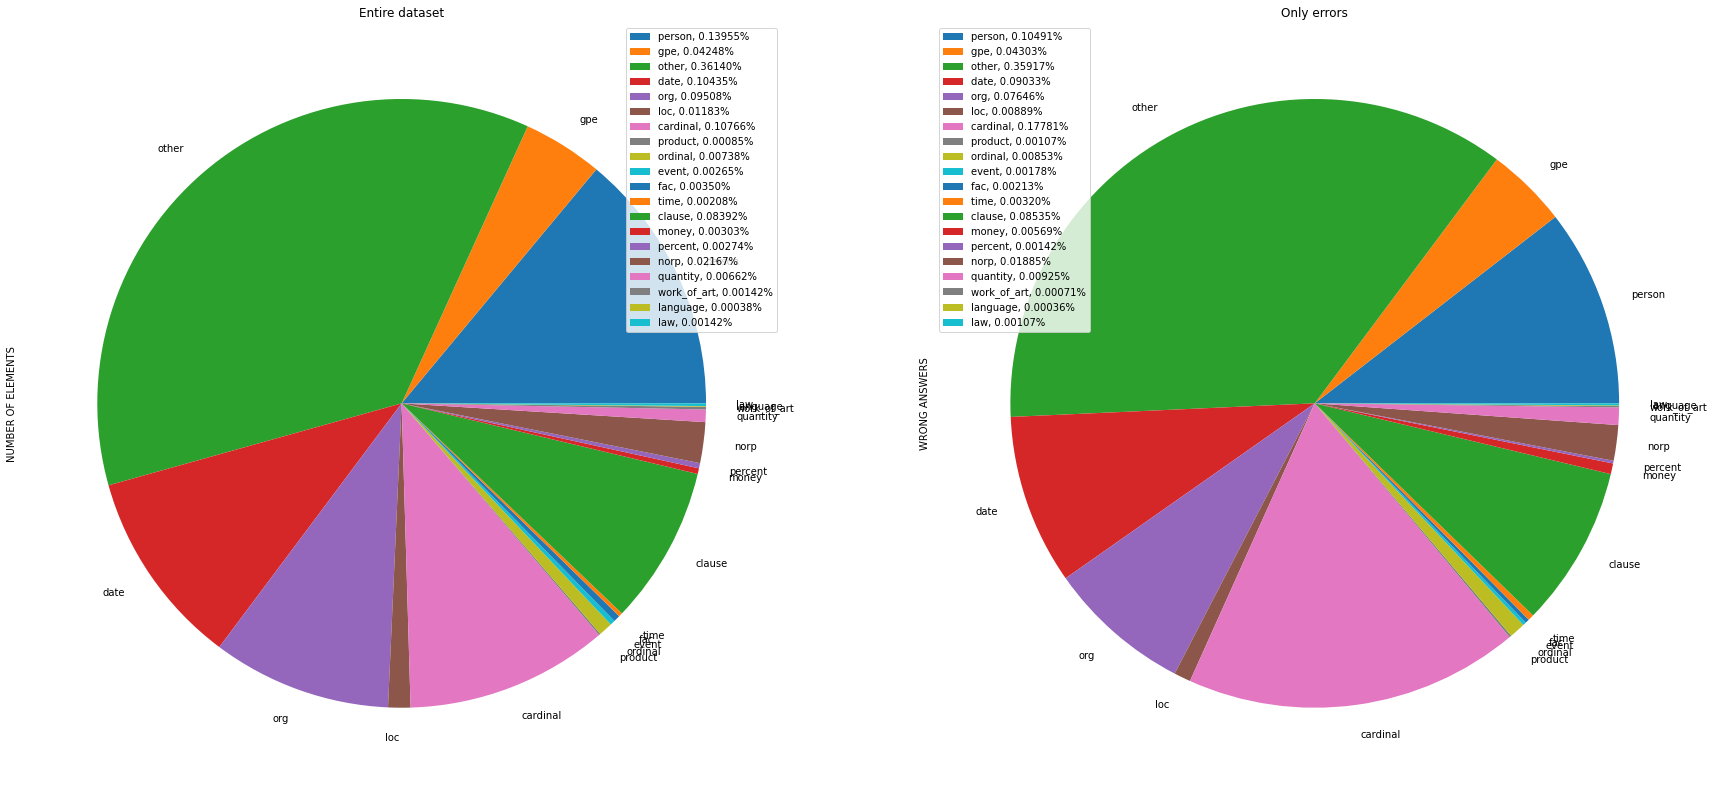

In [11]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(30,30))
ax1.set_title("Entire dataset")
errors_by_group.plot.pie(y='NUMBER OF ELEMENTS', ax=ax1);
labels = [f'{l}, {s:0.5f}%' for l, s in zip(list(errors_by_group.index), 
    errors_by_group['NUMBER OF ELEMENTS']/errors_by_group['NUMBER OF ELEMENTS'].sum())]
ax1.legend(labels)

ax2.set_title("Only errors")
errors_by_group.plot.pie(y='WRONG ANSWERS', ax=ax2);
labels = [f'{l}, {s:0.5f}%' for l, s in zip(list(errors_by_group.index), 
    errors_by_group['WRONG ANSWERS']/errors_by_group['WRONG ANSWERS'].sum())]

ax2.legend(labels)

The quantities of errors overall match the data distribution.

Now, we analyze some of the errors for each question category:

In [14]:
errors_by_group_sorted = errors_by_group.sort_values(by='WRONG ANSWERS', ascending=False)

for key in list(errors_by_group_sorted.index):
    samples = high_errors_df[high_errors_df["type"]==key].drop(["f1-score", "exact-score"], axis=1).sample(1)
    print(key)
    display(samples)
    print()

other


,type,question,answer,prediction,context
443,other,What is the Roman numeral for 50?,L,arabic numerals,"On June 4, 2014, the NFL announced that the pr..."



cardinal


,type,question,answer,prediction,context
5775,cardinal,How many stations did Boston have in 1952?,two,108 existing television stations in the united...,"In the fall of 1949, ABC found itself in the p..."



person


,type,question,answer,prediction,context
6119,person,What was the name of the wife arranged for Tem...,Börte,borte,"Temüjin had three brothers named Hasar, Hachiu..."



date


,type,question,answer,prediction,context
8699,date,When did Konstantin Mereschkowski suggest the ...,1905,1905 after andreas schimper observed in 1883,Chloroplasts are one of many types of organell...



clause


,type,question,answer,prediction,context
6584,clause,What is the receptor that killer T cells use t...,T cell receptor (TCR),tcr,Killer T cells are a sub-group of T cells that...



org


,type,question,answer,prediction,context
773,org,Which player was criticized for not jumping in...,Newton,"newton, and after several players dove for it,...","With 4:51 left in regulation, Carolina got the..."



gpe


,type,question,answer,prediction,context
4266,gpe,Which country did Rewe-Zentrale AG wish to imp...,France,"france, only had 15 to 20 per cent alcohol.","Often rules apply to all goods neutrally, but ..."



norp


,type,question,answer,prediction,context
10327,norp,What was causing New France to have issues wit...,British blockade of the French coastline,poor harvest,Vaudreuil and Montcalm were minimally resuppli...



quantity


,type,question,answer,prediction,context
4766,quantity,How much rain per year does Fresno get on aver...,11.5 inches,11. 5 inches,Fresno is marked by a semi-arid climate (Köppe...



loc


,type,question,answer,prediction,context
5001,loc,What did Biraben say about the plague in Europe?,the plague was present somewhere in Europe in ...,the plague was present,The plague repeatedly returned to haunt Europe...



ordinal


,type,question,answer,prediction,context
1051,ordinal,Where does Warsaw rank in terms of population ...,9th,9th most - populous capital city,Warsaw (Polish: Warszawa [varˈʂava] ( listen);...



money


,type,question,answer,prediction,context
1307,money,How much did Tesla say Edison offered him to r...,fifty thousand dollars,us $ 10 a week raise,Tesla was offered the task of completely redes...



time


,type,question,answer,prediction,context
2607,time,At what time did Martin Luther die?,2:45 a.m,18 february 1546,An apoplectic stroke deprived him of his speec...



fac


,type,question,answer,prediction,context
5195,fac,Why have Newcastle and Gateshead linked togeth...,to spearhead the regeneration of the North-East,""" newcastlegateshead",Large-scale regeneration has replaced former s...



event


,type,question,answer,prediction,context
509,event,Which committee made an effort to invite compa...,the Super Bowl 50 Host Committee,the super bowl 50 host committee and the nfl h...,"For the first time, the Super Bowl 50 Host Com..."



percent


,type,question,answer,prediction,context
941,percent,How much of Warsaw's population was Jewish?,some 30% of the city,several hundred thousand,After the German Invasion of Poland on 1 Septe...



product


,type,question,answer,prediction,context
3806,product,What did Mitsubishi rename its Forte to?,Dodge D-50,dodge d - 50,"Compact trucks were introduced, such as the To..."



law


,type,question,answer,prediction,context
4089,law,What are the two primary constitutional source...,the Treaty on European Union (TEU) and the Tre...,treaty on european union,Although the European Union does not have a co...



work_of_art


,type,question,answer,prediction,context
2365,work_of_art,When did Luther and his wife live?,", ""The Black Cloister,""",1525 – 32,Luther and his wife moved into a former monast...



language


,type,question,answer,prediction,context
10303,language,How were British able to cut supplies to Louis...,deportation of the French-speaking Acadian pop...,"to cut vital supplies to louisbourg, nova scot...","Colonel Monckton, in the sole British success ..."


We can see that:
- Some errors are related to having a few words more or less with respect to the ground truth answer
    - For instance, questions related to years often repeat a large part of the context, while the ground truth answer is simply the year.
- There are lots of errors that are due to our implementation of the answer extraction. 
    - Since the output indices are related to the sequence of tokens and not to the words in the paragraph, we actually decode the previously encoded tokens to extract the answer.
    - But this creates answers that are not necessarily part of the paragraph
    - Therefore, they may be valid answers (and in some of the presented cases, they are), but they are not *exactly* equal to the ground truth due to the addition of spaces or lowercase/uppercase letters
    - These are problems related to the tokenizer that have a huge impact in the performances
    - A solution to this problem might be changing the way we produce an answer by keeping track of the index transformation between tokens and character indices in the paragraph.
    - Or, in alternative, comparing our predicted answer to a decoded ground truth using the same tokenizer we used for the paragraph and the question.


## Dataset split difference

We have noticed a big difference in performances between validation and test sets, so we need to investigate this gap.